# Step_3c_Data_level_approach_Combination_under_oversampling

**In this notebook we will apply simple classification models after over, under_sampling combination technique to the minority class**

As we conclude in the notebook :metric_selection, we will use the roc-auc metric to evaluate the performance of the models and we will analyze the false negative ratio which is what we are interested in minimizing.

# CONTENT

    1. Import Libraries
    2. Load data
    3. Over, undersampling combination method
    4. Modeling:
        4.1 Logistic Regression
        4.2 k-Nearest Neighbor
        4.3 Decision Tree
        4.4 Support Vector Machine
        4.5 RandomForest
     5. Summary and Conlusions

# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np


#show cells with width as long as screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#Hide warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
pd.options.display.max_columns = None

#Samplind data
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

#Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
)

from sklearn.model_selection import GridSearchCV

#metric
from sklearn.metrics import roc_auc_score, plot_roc_curve, precision_recall_curve, accuracy_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

# 2. Load data

This data has been generated in the notebook: step_2_Preprocessing_data

In [2]:
X_train = pd.read_excel('X_train_step_2.xlsx', engine='openpyxl')
X_test =  pd.read_excel('X_test_step_2.xlsx', engine='openpyxl')
y_train = pd.read_excel('y_train_step_2.xlsx', engine='openpyxl')
y_test = pd.read_excel('y_test_step_2.xlsx', engine='openpyxl')

# 3. Over, undersampling combination method

SMOTE + ENN and SMOTE + Tomek Links

Combined used of SMOTE and ENN or Tomek Links to amplify the minority class and remove noisy observations that might be created.

In [3]:
under_oversampler_dict = {
    'smenn': SMOTEENN(
        sampling_strategy='auto',
        random_state=42,
        smote=SMOTE(sampling_strategy='auto', random_state=0, k_neighbors=5),
        enn=EditedNearestNeighbours(
            sampling_strategy='auto', n_neighbors=3, kind_sel='all'),
        n_jobs=4),

    'smtomek': SMOTETomek(
        sampling_strategy='auto',
        random_state=42,
        smote=SMOTE(sampling_strategy='auto', random_state=0, k_neighbors=5),
        tomek=TomekLinks(sampling_strategy='all'),
        n_jobs=4),

}

# 4. Modeling

## 4.1 Logistic Regression

In [4]:
def run_LogisticRegression(X_train, X_test, y_train, y_test):
    
    '''This function applies the logistic regression model with more conservative parameters.
    In order to evaluate the model performance it uses roc-auc metric.
    It prints predictions of train and test set in order to evaluate over or underfitting and 
    it also calculates the confusion matrix and False Positive Rate (FPR) Vs False Negative Rate (FNR) '''
        
    
    model = LogisticRegression(
    random_state=42,
    penalty='l1',
    C=0.1,
    max_iter=1000,
    solver = 'saga')
    
    model.fit(X_train, y_train)

    print('Train set')
    pred = model.predict_proba(X_train)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = model.predict_proba(X_test)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))
    
    #confusion matrix
    cf_matrix = confusion_matrix(y_test, model.predict(X_test))
    
    #False Positive Rate (FPR) Vs False Negative Rate (FNR)
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test), labels=[0,1]).ravel()

    FPR = fp / (tn + fp)

    FNR = fn / (tp + fn)
    

    return roc_auc_score(y_test, pred[:, 1]), cf_matrix, FPR, FNR

In [5]:
results_dict_LG = {}
shapes_dict_LG  = {}
conf_matrix_LG  = {}
FNR_dict_LG  = {}


for combination in under_oversampler_dict.keys():
    print(combination)
    
    #resample
    X_resampled, y_resampled = under_oversampler_dict[combination].fit_resample(X_train, y_train)
    
    #evaluate performance
    roc = run_LogisticRegression(X_resampled, X_test, y_resampled, y_test)
    
    
    
    #store results
    results_dict_LG [combination] = roc[0]
    conf_matrix_LG [combination] = roc[1]
    FNR_dict_LG [combination] = roc[3]
    shapes_dict_LG [combination] = len(X_resampled)  
    print()
    
print()

smenn
Train set
Logistic Regression roc-auc: 0.8782398016677935
Test set
Logistic Regression roc-auc: 0.5723981900452488

smtomek
Train set
Logistic Regression roc-auc: 0.8720438957475994
Test set
Logistic Regression roc-auc: 0.578054298642534




### **Summary of results**

a) summary of all roc-auc scores dependeng of sampling method

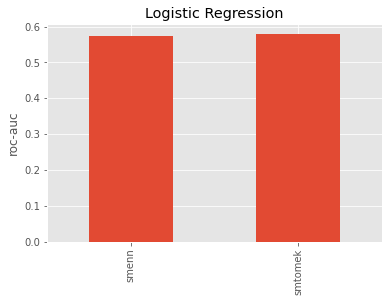

In [6]:
pd.Series(results_dict_LG).plot.bar()
plt.title('Logistic Regression')
plt.ylabel('roc-auc')

plt.show();

b) Confusion Matrix

In [7]:
conf_matrix_LG

{'smenn': array([[51, 17],
        [ 8,  5]], dtype=int64),
 'smtomek': array([[53, 15],
        [ 9,  4]], dtype=int64)}

c) False Negative Rate

In [8]:
FNR_dict_LG

{'smenn': 0.6153846153846154, 'smtomek': 0.6923076923076923}

## 4.2 k-Nearest Neighbors

In [9]:
def run_KNN_1(X_train, X_test, y_train, y_test):
    
    
    clf_gk = KNeighborsClassifier()

    param_grid={"n_neighbors":np.arange(1,13), 'p': [1,2]}
    


    grid_search_clf_gk = GridSearchCV(clf_gk, param_grid, cv = 3, n_jobs = -1, scoring='roc_auc') #ccv = 5-fold cross validation, n_jobs =# run in parallel
    grid_search_clf_gk.fit(X_train, y_train)
    
  
    #print('Train set')
    pred = grid_search_clf_gk.predict_proba(X_train)
    print('Decision Tree: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = grid_search_clf_gk.predict_proba(X_test)
    print('Decision Tree: {}'.format(roc_auc_score(y_test, pred[:,1])))
    
    #confusion matrix
    cf_matrix = confusion_matrix(y_test, grid_search_clf_gk.predict(X_test))
    
    #False Positive Rate (FPR) Vs False Negative Rate (FNR)
    tn, fp, fn, tp = confusion_matrix(y_test, grid_search_clf_gk.predict(X_test), labels=[0,1]).ravel()

    FPR = fp / (tn + fp)

    FNR = fn / (tp + fn)
     
    return roc_auc_score(y_test, pred[:, 1]), cf_matrix, FPR, FNR 

results_dict_KNN = {}
shapes_dict_KNN  = {}
conf_matrix_KNN  = {}
FNR_dict_KNN  = {}


for combination in under_oversampler_dict.keys():
    print(combination)
    
    #resample
    X_resampled, y_resampled = under_oversampler_dict[combination].fit_resample(X_train, y_train)
    
    #evaluate performance
    roc = run_KNN_1(X_resampled, X_test, y_resampled, y_test)
    
    
    
    #store results
    results_dict_KNN [combination] = roc[0]
    conf_matrix_KNN [combination] = roc[1]
    FNR_dict_KNN [combination] = roc[3]
    shapes_dict_LG [combination] = len(X_resampled)  
    print()
    
print()

smenn
Decision Tree: 0.9882803696191119
Test set
Decision Tree: 0.6719457013574661

smtomek
Decision Tree: 0.9876680384087793
Test set
Decision Tree: 0.6866515837104072




### Summary of results

a) Summary of all roc-auc scores dependeng of sampling method

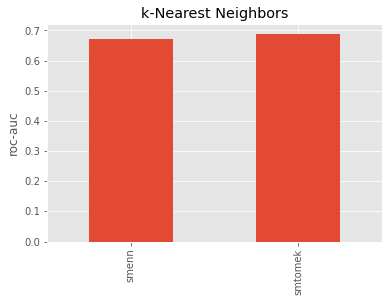

In [10]:
pd.Series(results_dict_KNN).plot.bar()
plt.title('k-Nearest Neighbors')
plt.ylabel('roc-auc')

plt.show();

b) Confusion Matrix

In [11]:
conf_matrix_KNN

{'smenn': array([[39, 29],
        [ 5,  8]], dtype=int64),
 'smtomek': array([[39, 29],
        [ 5,  8]], dtype=int64)}

c) False Negative Rate

In [12]:
FNR_dict_KNN

{'smenn': 0.38461538461538464, 'smtomek': 0.38461538461538464}

## 4.3 Decision Trees

In [13]:
def run_Decision_Tree(X_train, X_test, y_train, y_test):
    
    
    dtc = DecisionTreeClassifier()

    parameters = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : np.arange(1, 5),
    'min_samples_leaf' :  np.arange(1, 5),
    'min_samples_split' :  np.arange(1, 5),
    'splitter' : ['best', 'random']
        
}
    
    grid_search_dt = GridSearchCV(dtc, parameters, cv = 3, n_jobs = -1, scoring='roc_auc') #ccv = 5-fold cross validation, n_jobs =# run in parallel
    grid_search_dt.fit(X_train, y_train)
    
  
    
    print('Train set')
    pred = grid_search_dt.predict_proba(X_train)
    print('Decision Tree: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = grid_search_dt.predict_proba(X_test)
    print('Decision Tree: {}'.format(roc_auc_score(y_test, pred[:,1])))
    
    #confusion matrix
    cf_matrix = confusion_matrix(y_test, grid_search_dt.predict(X_test))
    
    #False Positive Rate (FPR) Vs False Negative Rate (FNR)
    tn, fp, fn, tp = confusion_matrix(y_test, grid_search_dt.predict(X_test), labels=[0,1]).ravel()

    FPR = fp / (tn + fp)

    FNR = fn / (tp + fn)
     
    return roc_auc_score(y_test, pred[:, 1]), cf_matrix, FPR, FNR 
    

results_dict_DT = {}
shapes_dict_DT  = {}
conf_matrix_DT  = {}
FNR_dict_DT  = {}
  
for combination in under_oversampler_dict.keys():
    print(combination)
    
    #resample
    X_resampled, y_resampled = under_oversampler_dict[combination].fit_resample(X_train, y_train)
    
    #evaluate performance
    roc = run_Decision_Tree(X_resampled, X_test, y_resampled, y_test)
    
    
    
    #store results
    results_dict_SVC [combination] = roc[0]
    conf_matrix_SVC [combination] = roc[1]
    FNR_dict_SVC [combination] = roc[3]
    shapes_dict_SVC [combination] = len(X_resampled)  
    print()
    
print()    

### Summary of results

a) Summary of all roc-auc scores dependeng of sampling method

IndexError: index 0 is out of bounds for axis 0 with size 0

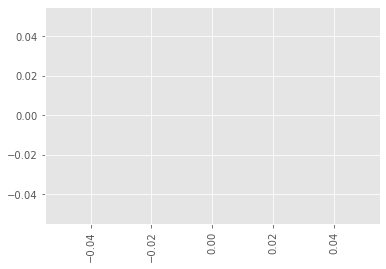

In [25]:
pd.Series(results_dict_DT).plot.bar()
plt.title('Decision Tree')
plt.ylabel('roc-auc')

plt.show();

b) Confusion Matrix

In [ ]:
conf_matrix

c) False Negative Rate

In [15]:
FNR_dict_DT

{}

## 4.4 Support Vector Machine

In [16]:
def run_SVC(X_train, X_test, y_train, y_test):
    
    clf_svc = SVC(probability = True, random_state = 42, kernel='rbf', gamma='scale', C=2)

   
    best_clf_svc = clf_svc.fit(X_train, y_train)
    
    print('Train set')
    pred = best_clf_svc.predict_proba(X_train)
    print('SVC: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = best_clf_svc.predict_proba(X_test)
    print('SVC: {}'.format(roc_auc_score(y_test, pred[:,1])))
    
    #confusion matrix
    cf_matrix = confusion_matrix(y_test, best_clf_svc.predict(X_test))
    
    #False Positive Rate (FPR) Vs False Negative Rate (FNR)
    tn, fp, fn, tp = confusion_matrix(y_test, best_clf_svc.predict(X_test), labels=[0,1]).ravel()

    FPR = fp / (tn + fp)

    FNR = fn / (tp + fn)
    
    
    
    return roc_auc_score(y_test, pred[:, 1]), cf_matrix, FPR, FNR 

results_dict_SVC = {}
shapes_dict_SVC  = {}
conf_matrix_SVC  = {}
FNR_dict_SVC = {}
FPR_dict_SVC  = {}


for combination in under_oversampler_dict.keys():
    print(combination)
    
    #resample
    X_resampled, y_resampled = under_oversampler_dict[combination].fit_resample(X_train, y_train)
    
    #evaluate performance
    roc = run_SVC(X_resampled, X_test, y_resampled, y_test)
    
    
    
    #store results
    results_dict_SVC [combination] = roc[0]
    conf_matrix_SVC [combination] = roc[1]
    FNR_dict_SVC [combination] = roc[3]
    shapes_dict_SVC [combination] = len(X_resampled)  
    print()
    
print()

smenn
Train set
SVC: 0.9922949064683344
Test set
SVC: 0.5565610859728507

smtomek
Train set
SVC: 0.9914540466392318
Test set
SVC: 0.5509049773755657




### Summary of results

a) Summary of all roc-auc scores dependeng of sampling method

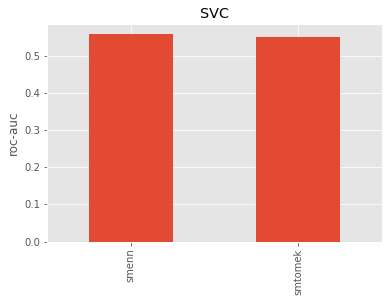

In [17]:
pd.Series(results_dict_SVC).plot.bar()
plt.title('SVC')
plt.ylabel('roc-auc')

plt.show();

b) Confusion Matrix

In [18]:
conf_matrix_SVC

{'smenn': array([[63,  5],
        [10,  3]], dtype=int64),
 'smtomek': array([[62,  6],
        [ 9,  4]], dtype=int64)}

c) False Negative Rate

In [19]:
FNR_dict_SVC

{'smenn': 0.7692307692307693, 'smtomek': 0.6923076923076923}

## 4.5 RandomForest

In [20]:
def run_RF(X_train, X_test, y_train, y_test):
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=3)
    best_clf_rf=rf.fit(X_train, y_train)
    
    
    print('Train set')
    pred = best_clf_rf.predict_proba(X_train)
    print('Random Forest roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = best_clf_rf.predict_proba(X_test)
    print('Random Forest roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))
    
    #confusion matrix
    cf_matrix = confusion_matrix(y_test, best_clf_rf.predict(X_test))
    
    #False Positive Rate (FPR) Vs False Negative Rate (FNR)
    tn, fp, fn, tp = confusion_matrix(y_test, best_clf_rf.predict(X_test), labels=[0,1]).ravel()

    FPR = fp / (tn + fp)

    FNR = fn / (tp + fn)
    
    return roc_auc_score(y_test, pred[:, 1]), cf_matrix, FPR, FNR


results_dict_RF = {}
shapes_dict_RF  = {}
conf_matrix_RF  = {}
FNR_dict_RF = {}
FPR_dict_RF  = {}


for combination in under_oversampler_dict.keys():
    print(combination)
    
    #resample
    X_resampled, y_resampled = under_oversampler_dict[combination].fit_resample(X_train, y_train)
    
    #evaluate performance
    roc = run_RF(X_resampled, X_test, y_resampled, y_test)
    
    
    
    #store results
    results_dict_RF[combination] = roc[0]
    conf_matrix_RF [combination] = roc[1]
    FNR_dict_RF [combination] = roc[3]
    shapes_dict_RF [combination] = len(X_resampled)  
    print()
    
print()

smenn
Train set
Random Forest roc-auc: 0.9530721771467208
Test set
Random Forest roc-auc: 0.6730769230769231

smtomek
Train set
Random Forest roc-auc: 0.9591358024691358
Test set
Random Forest roc-auc: 0.6821266968325792




### Summary of results

a) Summary of all roc-auc scores dependeng of sampling method

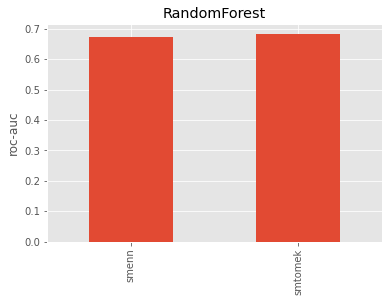

In [21]:
pd.Series(results_dict_RF).plot.bar()
plt.title('RandomForest')
plt.ylabel('roc-auc')

plt.show();

b) Confusion Matrix

In [22]:
conf_matrix_RF

{'smenn': array([[55, 13],
        [ 9,  4]], dtype=int64),
 'smtomek': array([[51, 17],
        [ 8,  5]], dtype=int64)}

c) False Negative Rate

In [23]:
FNR_dict_RF

{'smenn': 0.6923076923076923, 'smtomek': 0.6153846153846154}